In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PHONE_TABLE = """
sil spn 
a aj aw 
o ow
ə ɥ 
e ej  
i io
j w u y
p pʰ m f
t tʰ n l
k kʰ x 
tɕ tɕʰ  
ʈʂ ʈʂʰ ʂ ʐ ʐ̩
ts tsʰ ɕ
z z̩ s 
ŋ ŋ̍ ɻ ʔ
"""

In [3]:
import sys
if "../src" not in sys.path:
    sys.path.append("../../src")
    
import json
import pandas as pd
from pathlib import Path
from itertools import chain
from typing import cast, Dict
from tqdm.auto import tqdm
import numpy as np

In [4]:
%%bash
cd ../../data/fst
decode-faster xianzai_var.fst ark:xianzai_phone_loglik.ark ark:ali_var.ark
copy-int-vector --binary=false ark:ali_var.ark ark,t:ali_var.txt


decode-faster xianzai_var.fst ark:xianzai_phone_loglik.ark ark:ali_var.ark 
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance LJH_GY_1479 is -0.260578 over 10 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance HRT_GY_6636 is -0.159635 over 16 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance ZFN_GY_5622 is -0.15553 over 32 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance LYY_GY_1389 is -0.240624 over 57 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance ZJZ_GY_0085 is -0.144928 over 36 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance XHR_GY_4087 is -0.347052 over 31 frames.
LOG (decode-faster[5.5.1068]:main():bin/decode-faster.cc:139) Log-like per frame for utterance XHR_GY_2354 is

## Decode phone-level variants

In [5]:
import numpy as np
from pathlib import Path
from kaldiio.matio import load_ark
ali_results = Path("../../data/fst/ali_var.txt").read_text().strip().split("\n")
ali_map = {
    vals[0]: np.array([int(x) for x in vals[1:]])
    for vals in [x.split() for x in ali_results]
}
lgmmprob_map = {k: v for k, v in load_ark("../../data/fst/xianzai_phone_loglik.ark")}


In [6]:
phone_table = PHONE_TABLE.strip().replace("\n", " ").split()

In [19]:
ali_seq

array([38, 38, 38, 38, 38, 38, 38, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3])

In [7]:
from collections import Counter

realized_phones = {}
for utt_id, ali_seq in ali_map.items():    
    ali_phones = [phone_table[x-1] for x in ali_seq]
    dedup = []
    for x in ali_phones:
        if not dedup:
            dedup.append(x)
            continue
        if x != dedup[-1]:
            dedup.append(x)
    if ali_phones[-1] != dedup[-1]:
        dedup.append(ali_phones[-1])
    dedup = " ".join(dedup)
    realized_phones.setdefault(dedup, []).append(utt_id)
common_rzs = sorted(realized_phones.items(), key=lambda x: len(x[1]), reverse=True)
[(k, len(v)) for k, v in common_rzs[:10]]

[('ɕ j e n ts aj', 315),
 ('ɕ j e n aj', 94),
 ('ɕ j e aj', 75),
 ('ɕ j e n a', 58),
 ('ɕ j e n ts a', 51),
 ('ɕ j e a', 49),
 ('ɕ j a aj', 30),
 ('ɕ j a', 21),
 ('ɕ e n ts aj', 19),
 ('ɕ j e ts aj', 18)]

In [9]:
realized_phones["ɕ j a aj"][:10]

['GYX_GY_3192',
 'WRW_GY_4463',
 'CJW_GY_3580',
 'CJW_GY_6329',
 'XYR_GY_1135',
 'CSW_GY_0255',
 'WJL_GY_3102',
 'CJW_GY_3267',
 'XYR_GY_1139',
 'ZMX_GY_0040']

## Decoded

Text(0.5, 1.0, 'Decoded YQY_GY_3340')

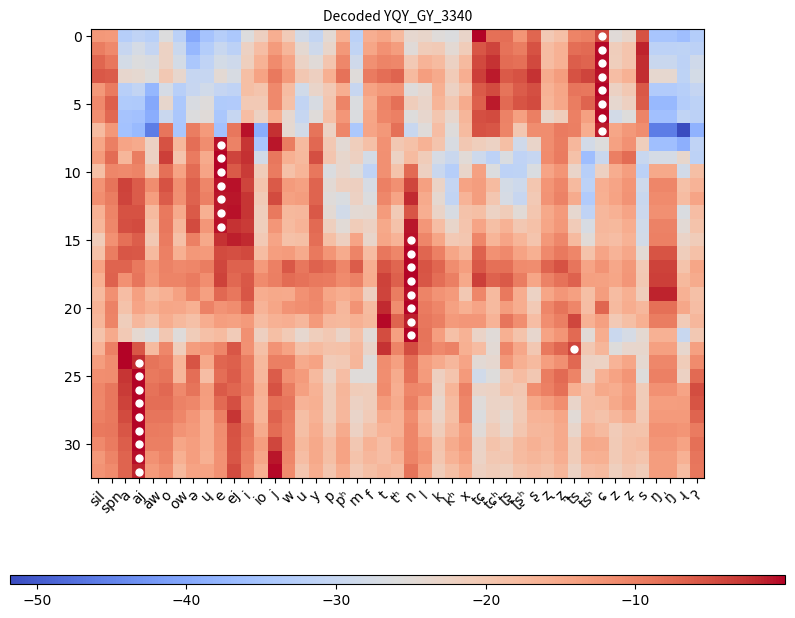

In [17]:
import matplotlib.pyplot as plt
phone_table = phone_table
tgt_utt_id = realized_phones["ɕ e n ts aj"][10]
pmat = lgmmprob_map[tgt_utt_id]
ali_idxs = ali_map[tgt_utt_id]

fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
plt.imshow(pmat, 
            cmap="coolwarm")

xticks = range(0, len(phone_table), 1)
xticklabels = [phone_table[y] for y in xticks]
plt.plot(ali_idxs-1, np.arange(len(ali_idxs)), color="white", ms=5, marker="o", ls="none")
plt.xticks(xticks, xticklabels, rotation=45) 
plt.colorbar(location="bottom", aspect=80)
plt.title(f"Decoded {tgt_utt_id}", fontsize=20, font="Noto Sans CJK JP")
# fig.savefig(str(fig_dir/f"{utt_x.utt_id}_{word_x.label}.png"))

In [18]:
from pathlib import Path
from IPython.display import Audio
wav_dir = Path(f"~/lago/mfa_data/xianzai/s1/").expanduser()
Audio(wav_dir/f"{tgt_utt_id}.wav", rate=22050)